Module importing

In [1]:
import sys
import torch
import random
import numpy as np
import torch.nn as nn
import torch.optim as optim
import scipy.signal as signal
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset

sys.path.append('/workspace/my_tool/model')
from multiResUnet_1D import MultiResUnet
sys.path.append('/workspace/my_tool/tool')
from model_builder import k_fold_training
from performance import performance
sys.path.append('/workspace/my_tool/tool/data_load')
from ppg_labeled_load import PPGDataset

Data prepairing

(1024,)


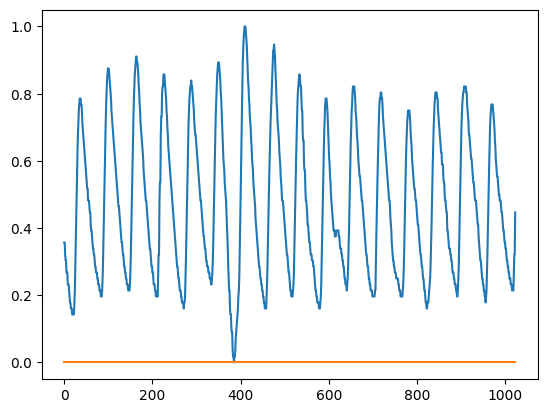

438
2190


In [2]:
def preprocess(data):
    if np.sum(data["Syn_Label"])>1:
        signal = data["Syn_PPG"]
        label = [1 if x > 0 else x for x in data["Syn_Label"]]
    return signal,label

#AF = 1, PAC,PVC = 2
def preprocess_case_1(data):
    s = data["Syn_PPG"]
    l = [2 if x in [3,4,5,6,7,8,9,10,11] else x for x in data["Syn_Label"]]
    return s,l

#AF = 1, PAC,PVC = 2, PAC,PVC-couple = 3
def preprocess_case_2(data):
    s = data["Syn_PPG"]
    l = [2 if x in [3,4] else x for x in data["Syn_Label"]]
    l = [3 if x in [5,6,7,8,9,10,11] else x for x in data["Syn_Label"]]
    return s,l

#Import_data
dataset = PPGDataset('/workspace/data/packaged_data',preprocessing=preprocess_case_2)
index = random.randint(0, len(dataset)-1)
z = dataset[0][0].numpy().flatten()
print(z.shape)
plt.plot(dataset[0][0].numpy().flatten())
plt.plot(dataset[0][1].numpy().flatten())
plt.show()

N = len(dataset)
test_len = int(N*0.2)
train_len = N-test_len

train_data, test_data = random_split(dataset, [train_len, test_len])
print(len(test_data))
print(len(dataset))

Training

In [5]:
import torch.nn.functional as F

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

para = {"Number class":         1,
			"Serie length":         1024, #The length of the 1D data
            "Filter nums":          [32,64,128], #The number of filters for each multiresblocks of one side of the model (1xn) 
            "Expand":               [2,2,2], #The number of stride (1x[n-1])
			"Respath kernel":       3, #The kernel size of each respath (1x1)
            "Block kernel":         [3,5,7], #The kernel size of each multiresblocks (1x3)
			"Filter rate":          [1.67,0.333,0.5], #The ratio of filer number of each multiresblock (1x3)
			"Pooling kernel":       [2,2,2], #The kernel size of each pooling layer (1xn)
			"Transpose kernel":     [2,2,2]	#
    }

def loss(predict, truth):
    truth = truth.to(torch.int64)  # Ensure labels are int64 for PyTorch compatibility
    log_prob = F.log_softmax(predict, dim=1)  # Compute log-softmax
    loss = -log_prob.gather(dim=1, index=truth.unsqueeze(1)).squeeze(1)  # Gather log probabilities of the correct classes
    return loss.mean()

model = MultiResUnet(para = para, alpha = 1.67)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
builder = k_fold_training(train_data, 1, criterion = nn.MSELoss())
builder.training(model,device,optimizer,num_epochs=1000,batch=64,visualize=1)

True
Iteration: 1/1000. loss_train: 1.265545625771795. loss_val: 0
Iteration: 2/1000. loss_train: 0.9327744394540787. loss_val: 0
Iteration: 3/1000. loss_train: 0.855633197086198. loss_val: 0
Iteration: 4/1000. loss_train: 0.7752807502235685. loss_val: 0
Iteration: 5/1000. loss_train: 0.7236560508608818. loss_val: 0
Iteration: 6/1000. loss_train: 0.6254175486309188. loss_val: 0
Iteration: 7/1000. loss_train: 0.5837869229061263. loss_val: 0
Iteration: 8/1000. loss_train: 0.5566577804940087. loss_val: 0
Iteration: 9/1000. loss_train: 0.4939256023083414. loss_val: 0
Iteration: 10/1000. loss_train: 0.49721602350473404. loss_val: 0
Iteration: 11/1000. loss_train: 0.6104017304522651. loss_val: 0
Iteration: 12/1000. loss_train: 0.5037312699215752. loss_val: 0
Iteration: 13/1000. loss_train: 0.4488435057657106. loss_val: 0
Iteration: 14/1000. loss_train: 0.4600723258086613. loss_val: 0
Iteration: 15/1000. loss_train: 0.43784145904438837. loss_val: 0
Iteration: 16/1000. loss_train: 0.4150966799

KeyboardInterrupt: 

Performance

Max loss:  5.4350233
Mean loss:  0.13064356
Min loss:  0.02086279
Number of test:  438


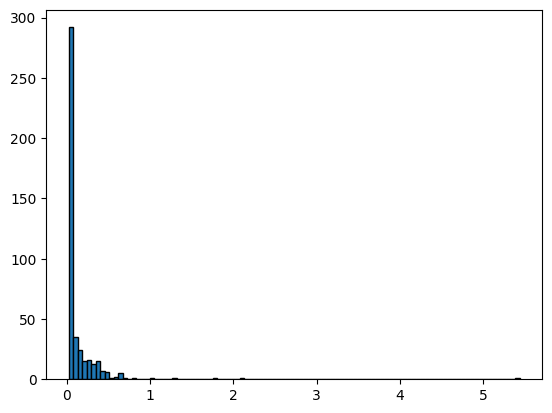

0.02308775


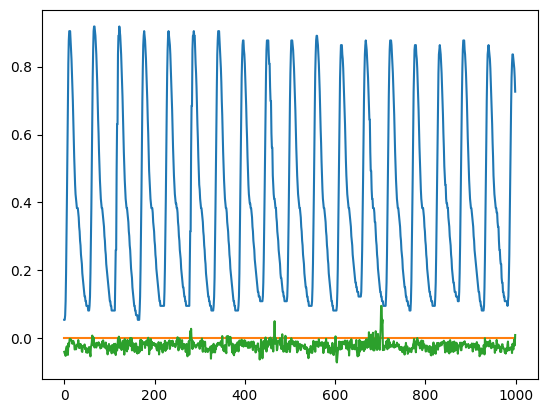

0.02238948


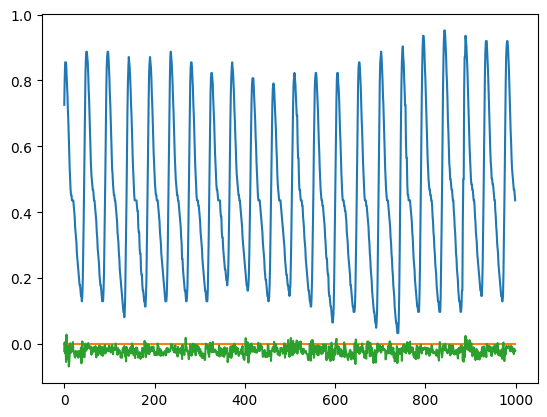

0.02439915


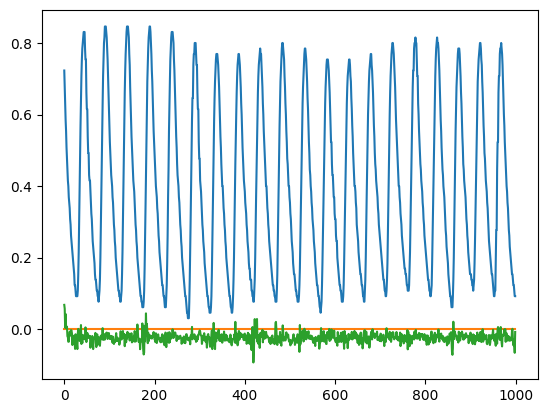

0.02230537


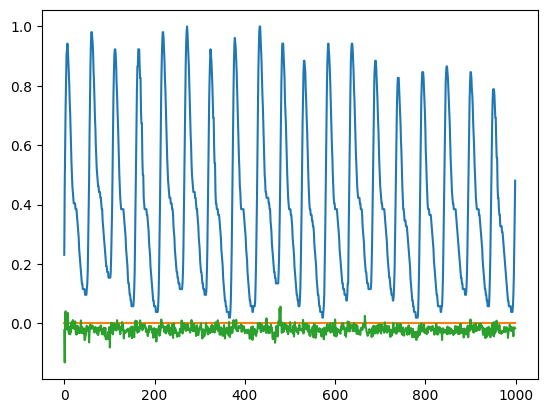

0.0257851


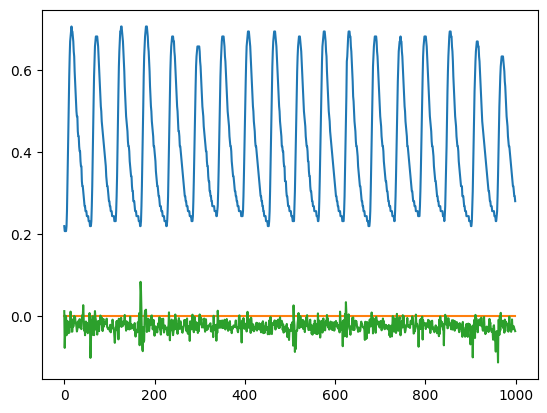

0.027857276


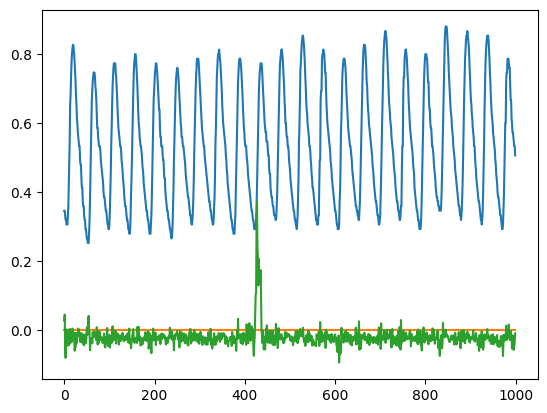

0.023966022


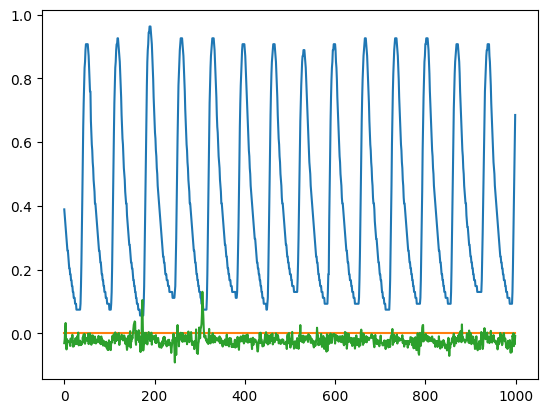

0.14839497


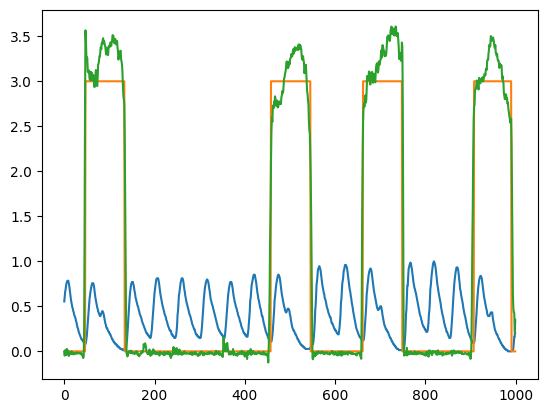

0.02427711


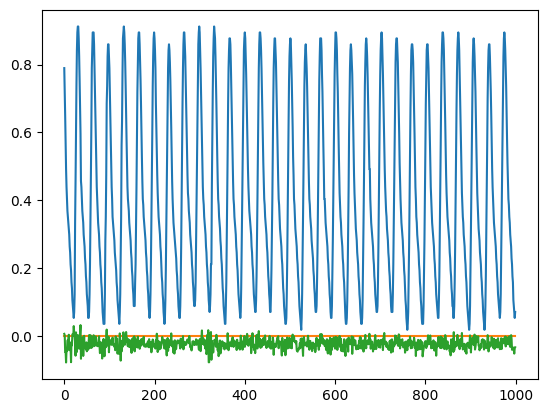

0.024764035


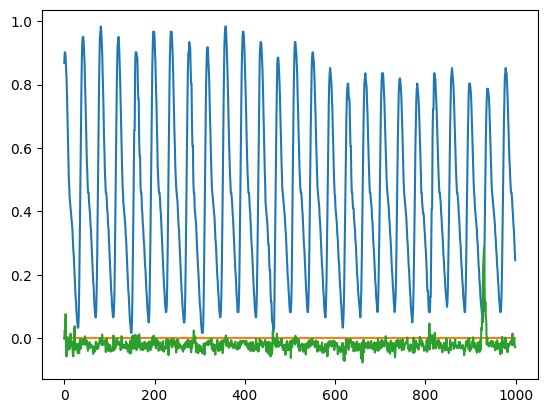

0.023166575


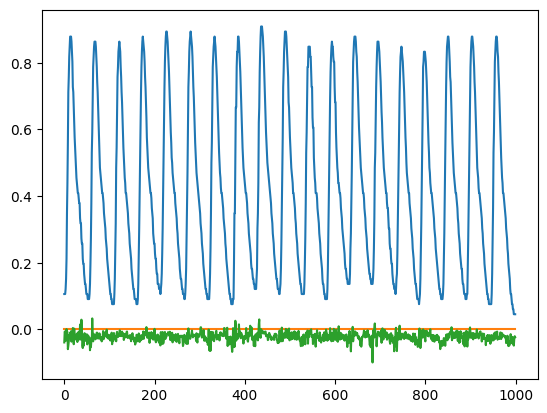

0.026138999


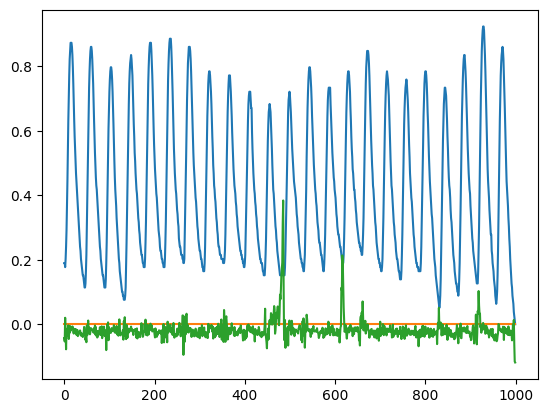

0.06763077


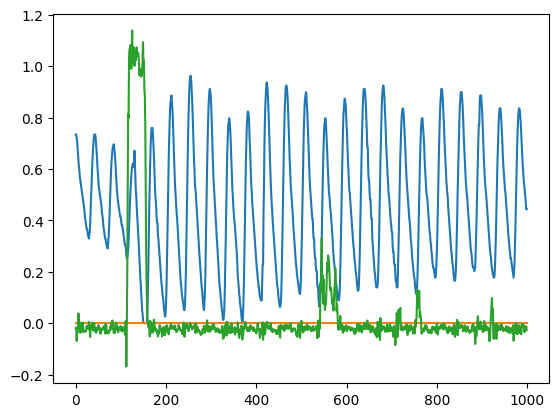

0.039241858


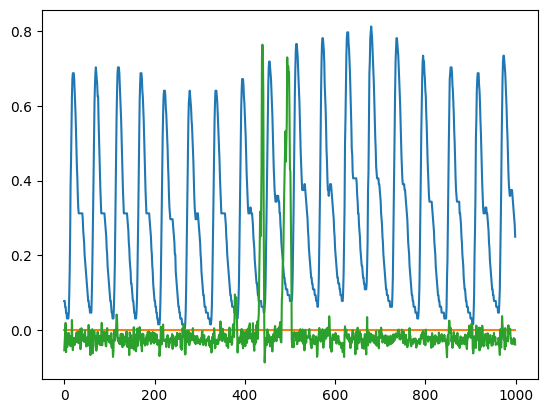

0.024654945


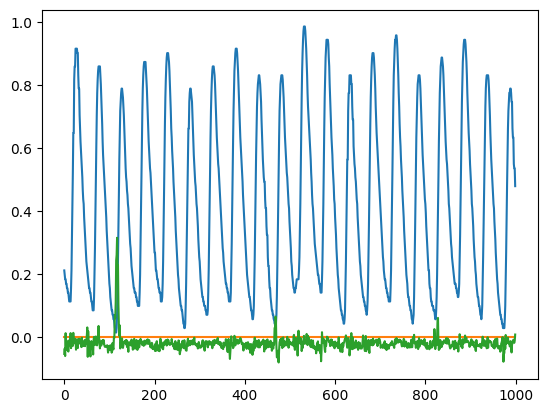

0.023360193


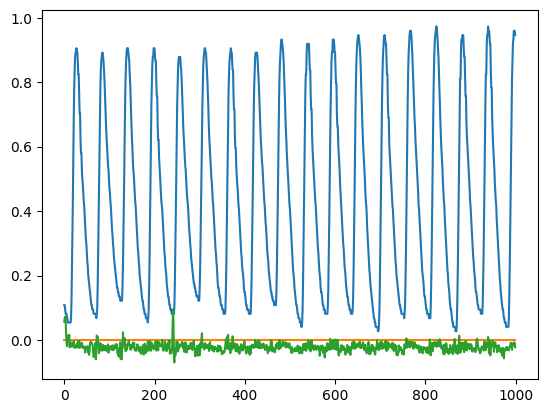

0.023708034


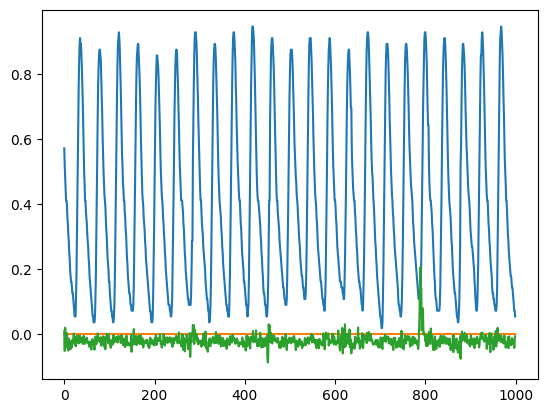

0.04033529


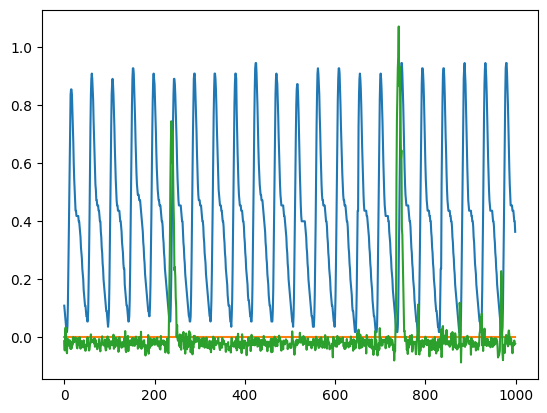

0.025419


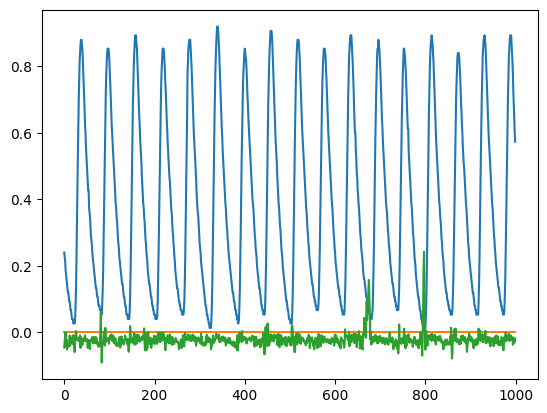

0.15699281


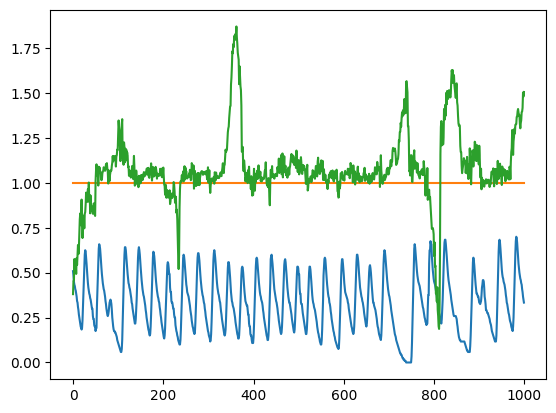

0.021899492


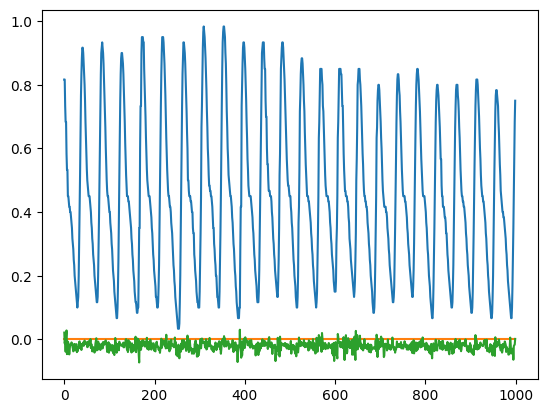

0.27232087


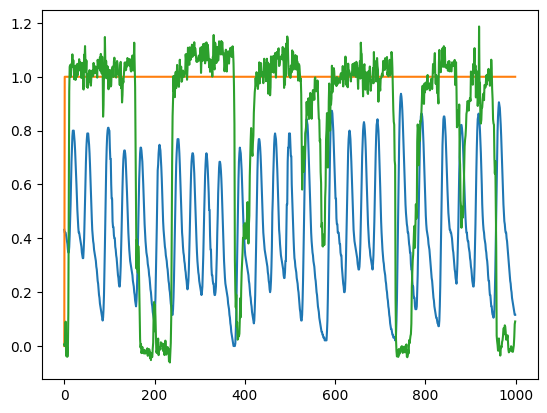

0.026333202


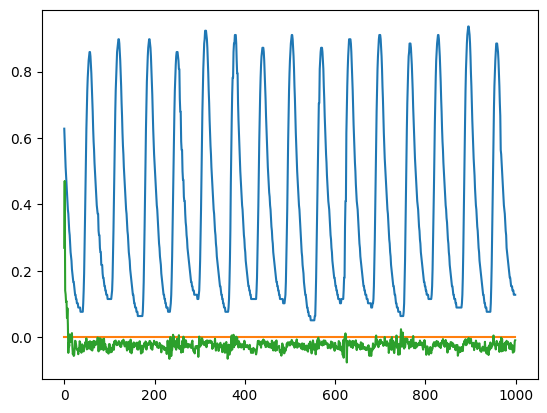

0.39659828


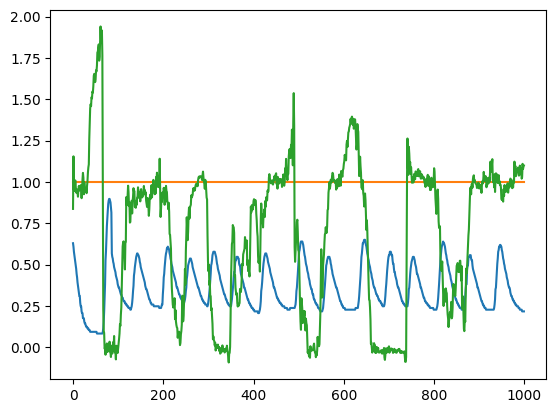

0.20047277


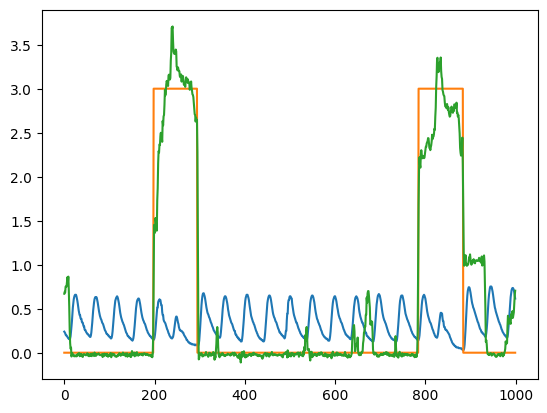

0.03747123


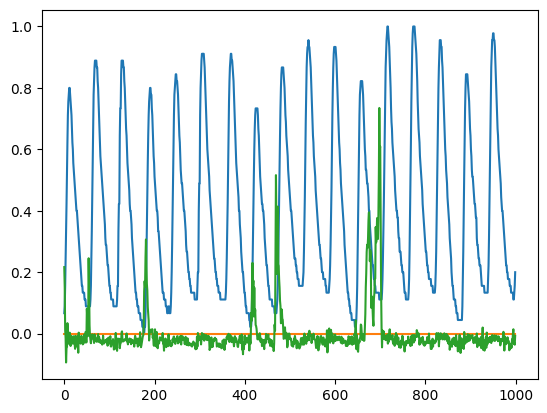

0.02183657


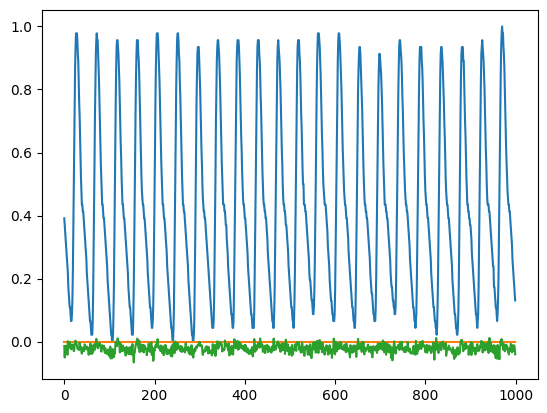

0.12603602


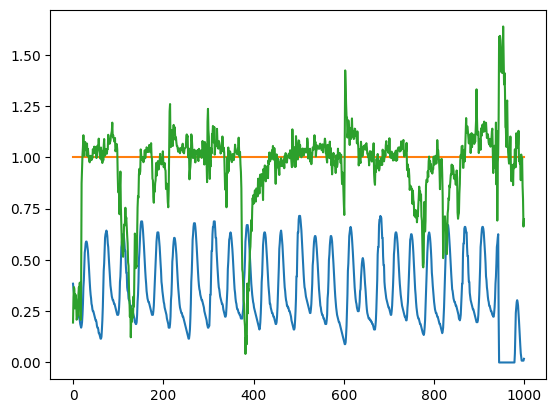

0.02395337


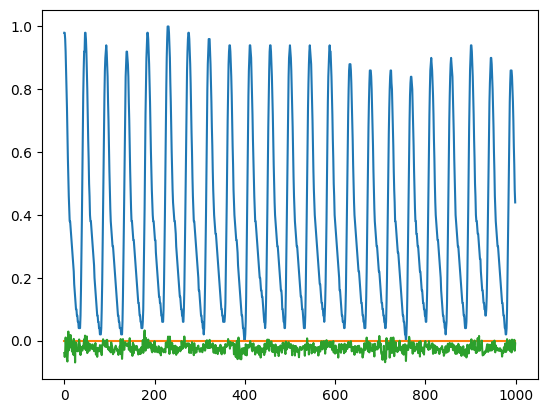

0.022767551


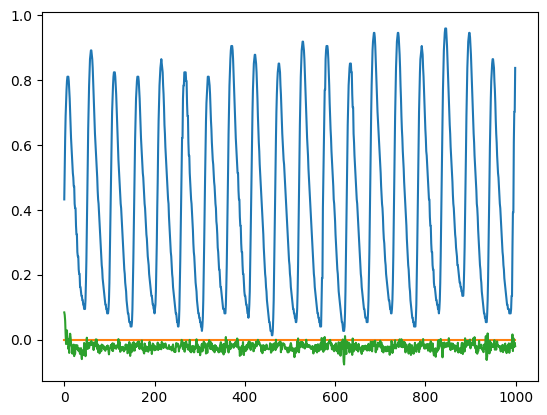

0.43384182


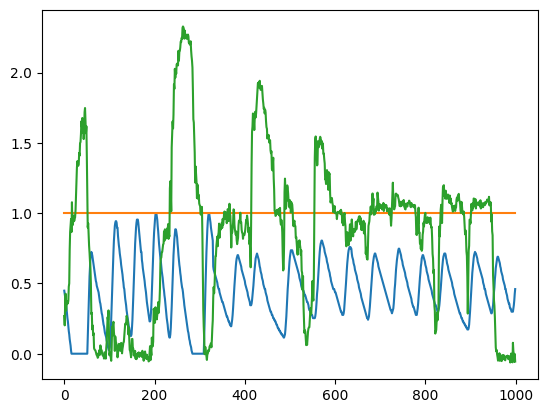

0.024443863


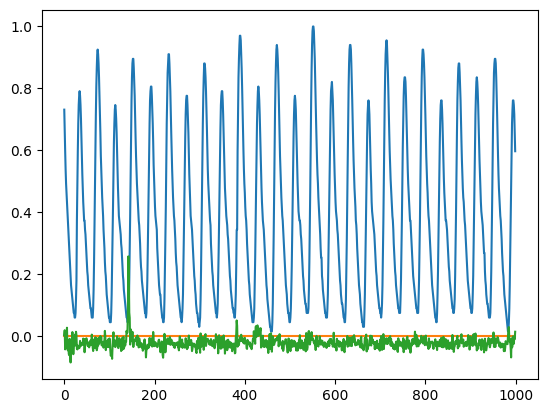

0.033135228


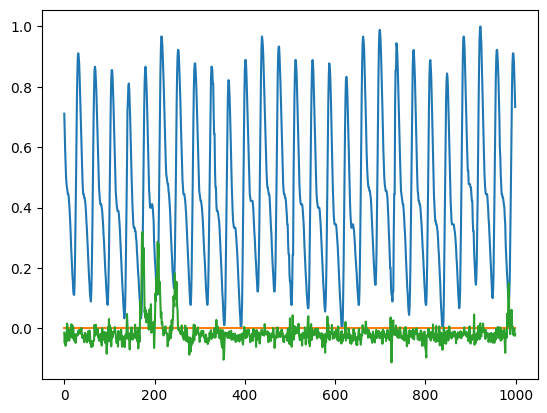

0.21174534


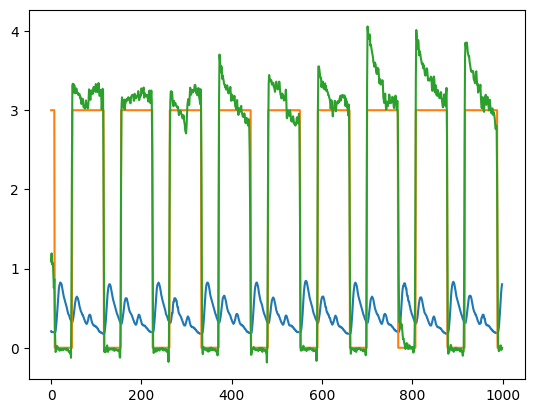

0.04825148


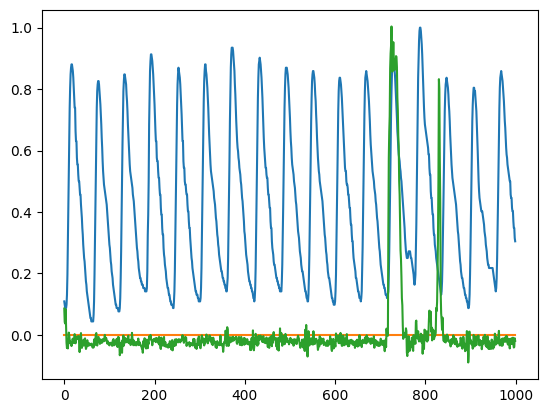

0.1824741


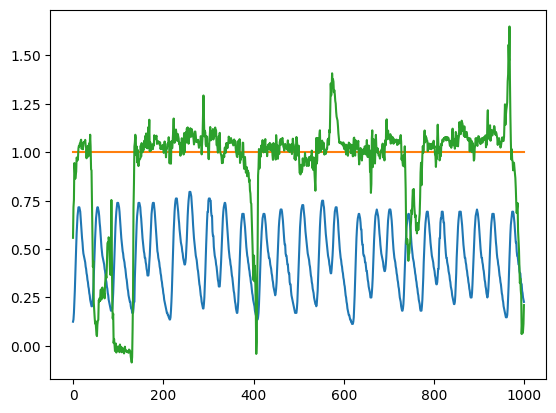

0.23906371


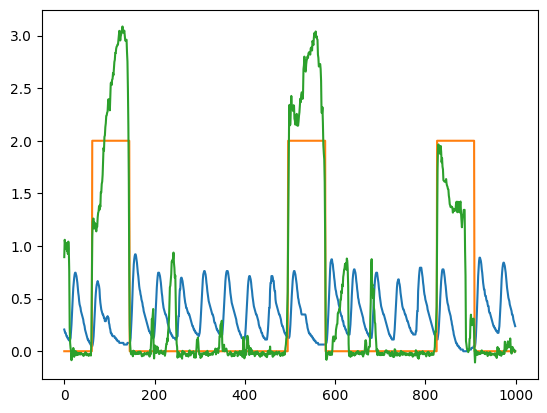

0.027800957


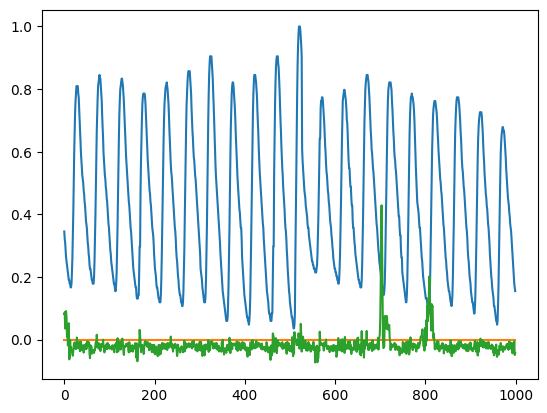

0.035629623


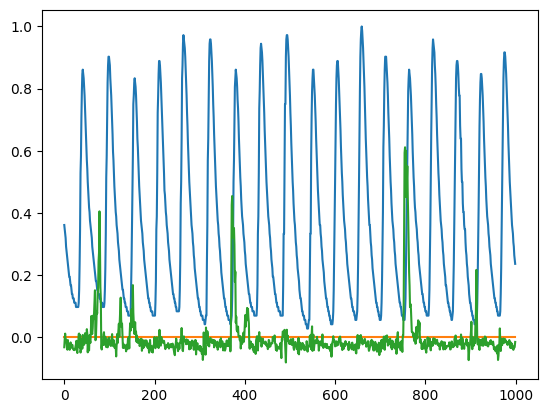

0.023734845


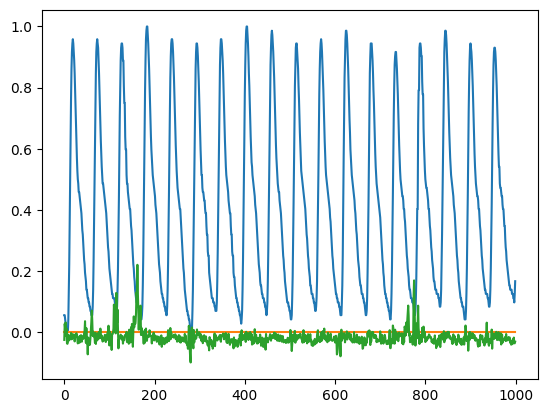

0.044089355


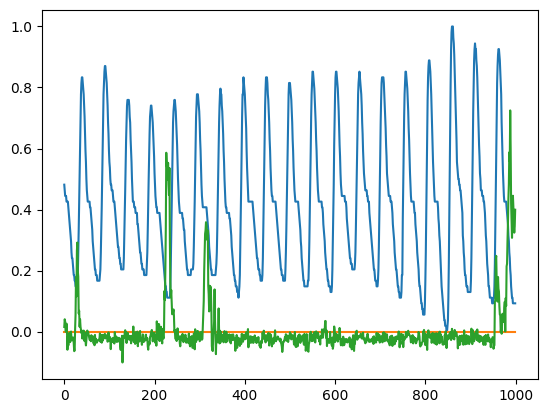

0.3739131


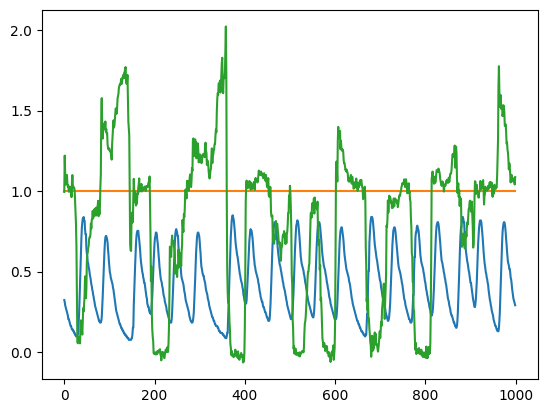

0.023911458


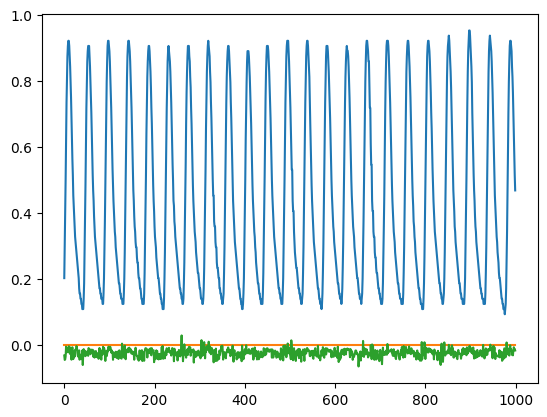

0.024048578


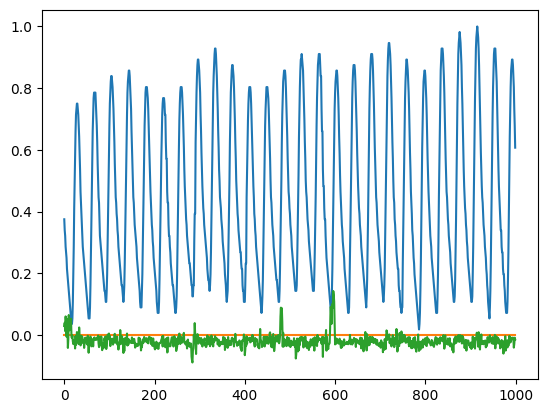

0.027975885


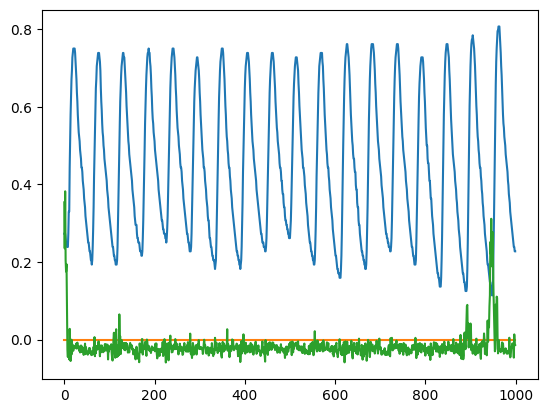

0.023172116


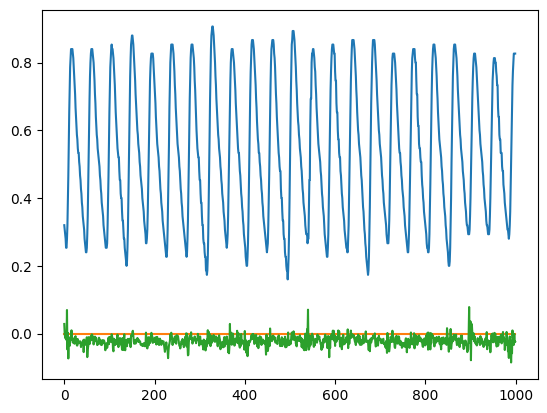

0.324425


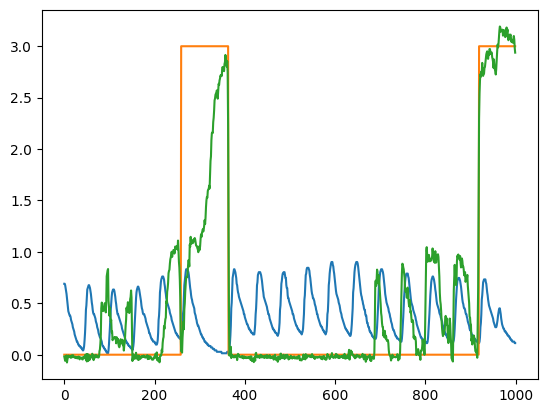

0.0235244


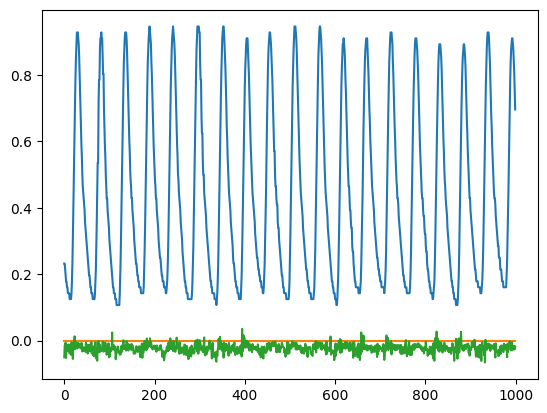

0.024990259


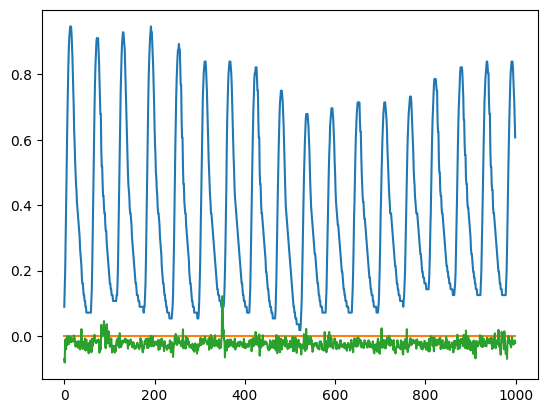

0.023119805


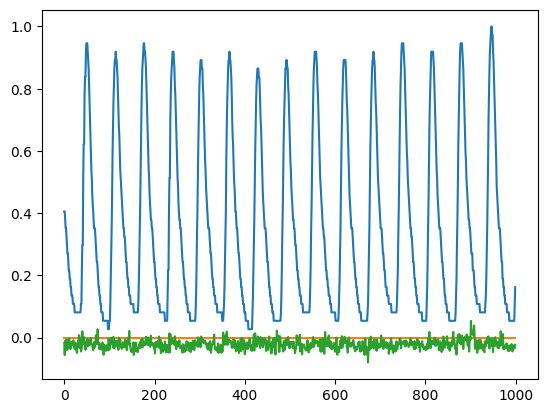

0.06463614


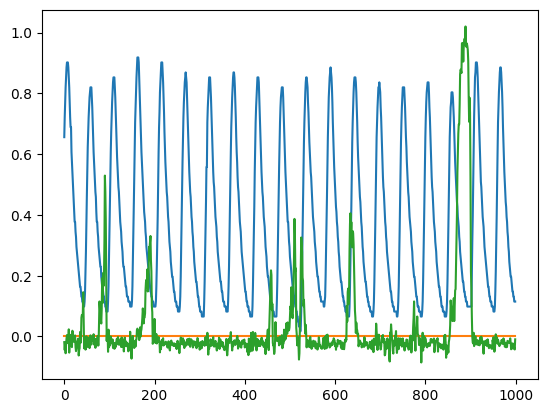

0.068086565


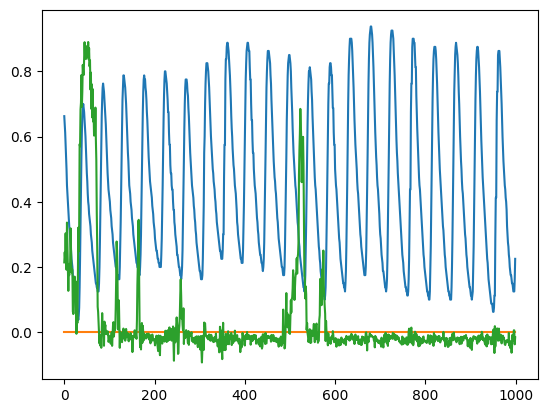

0.10331926


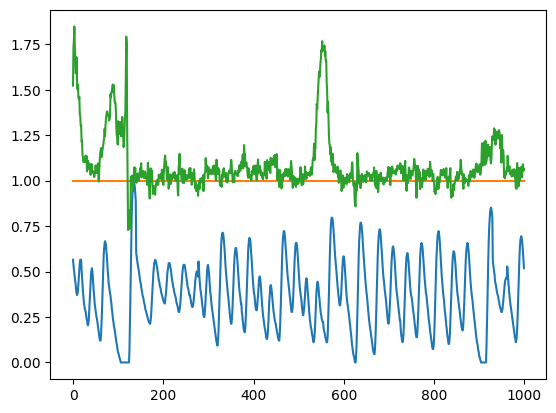

0.1751256


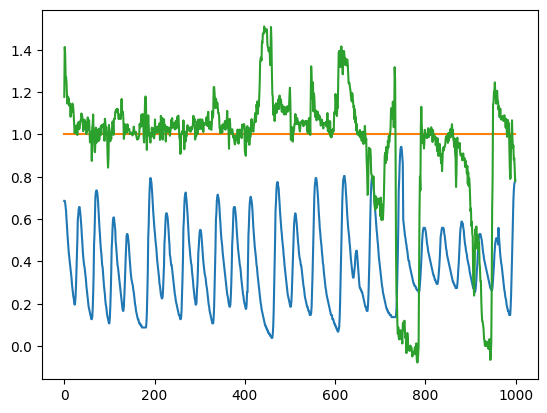

0.023156349


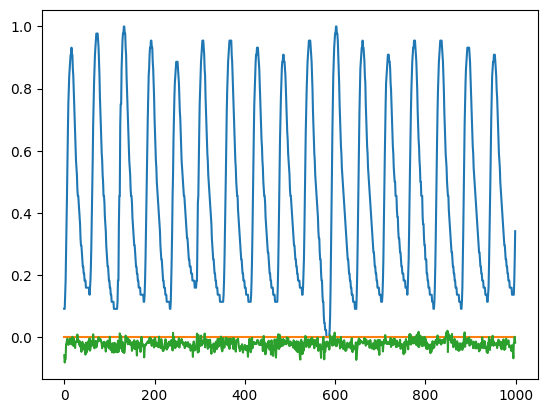

0.023927968


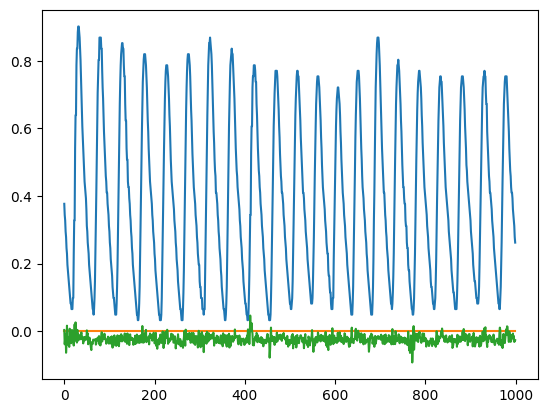

0.20656338


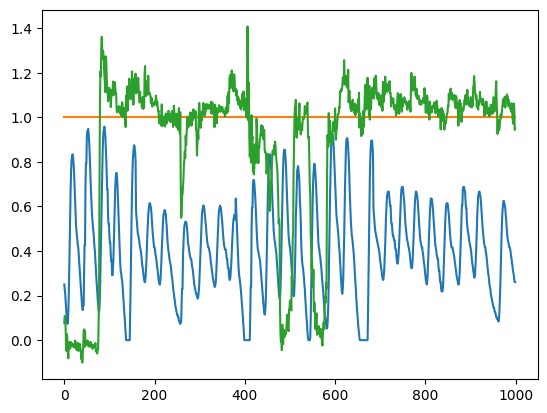

0.5515634


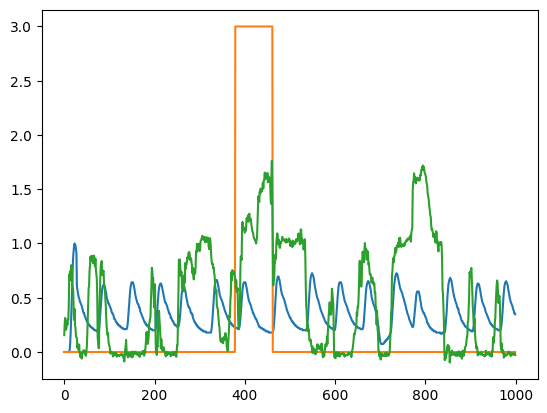

0.031100152


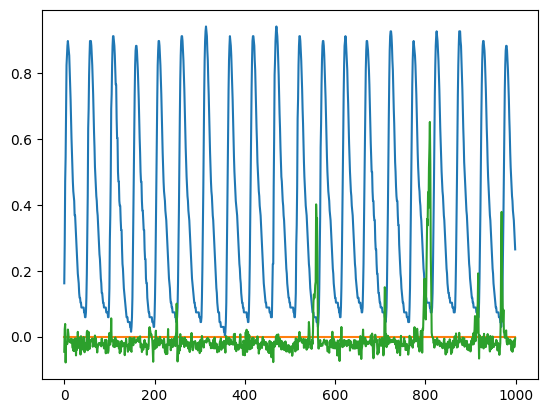

0.02249059


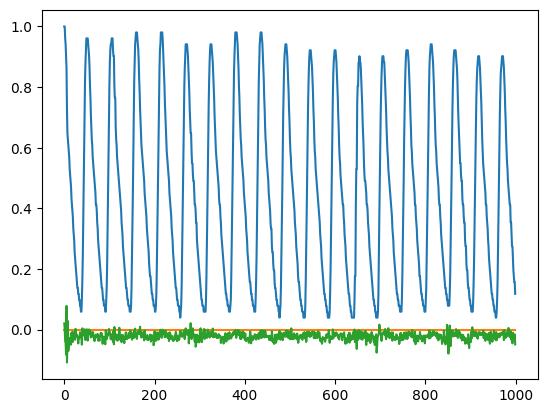

0.25462022


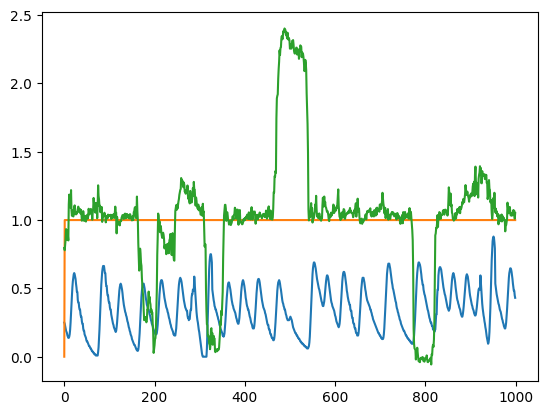

0.13677828


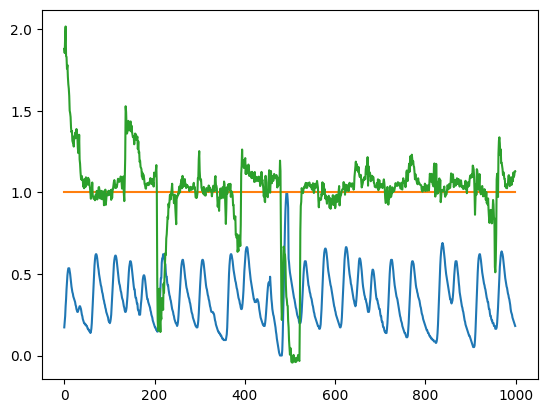

0.08868161


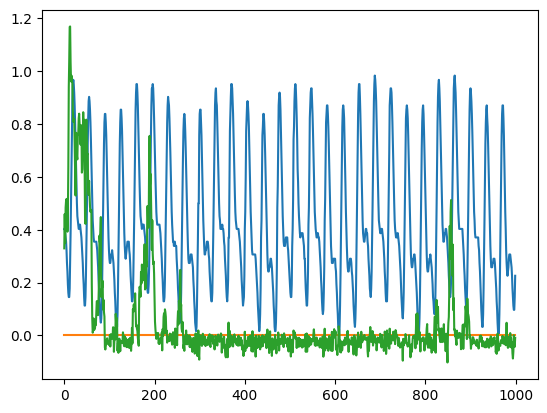

0.022265902


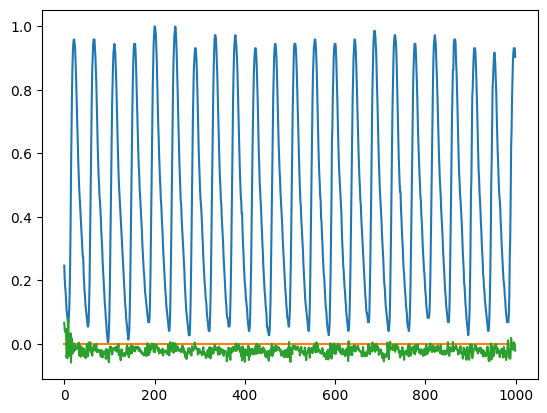

0.3809299


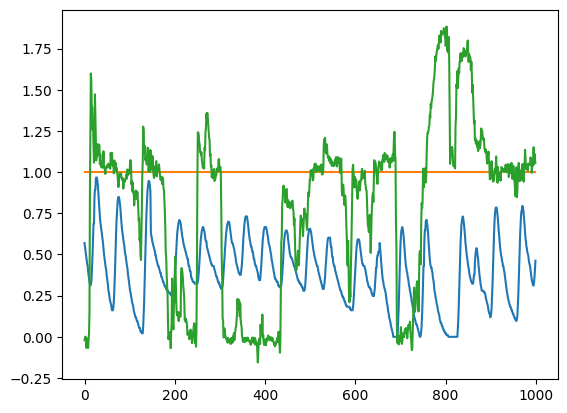

0.023976812


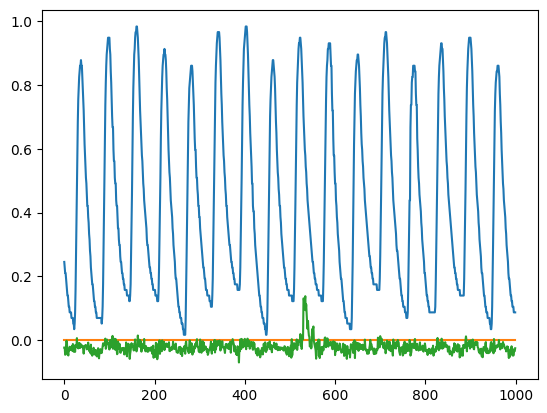

0.41129774


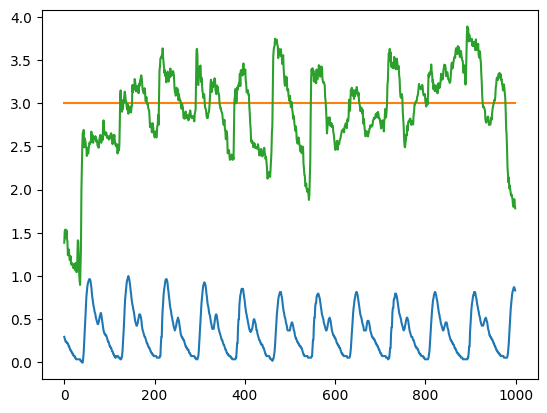

0.046928637


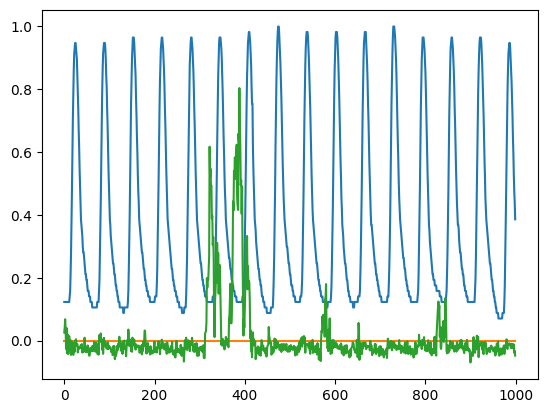

0.2162948


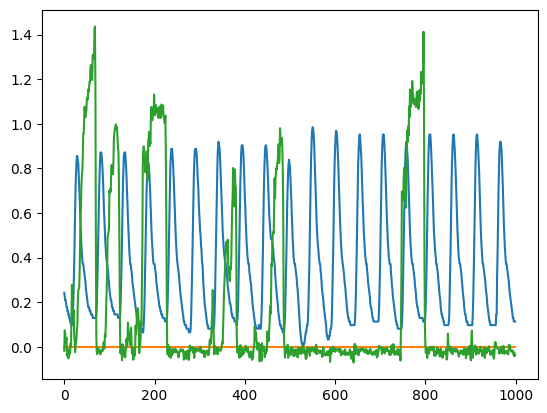

0.02172301


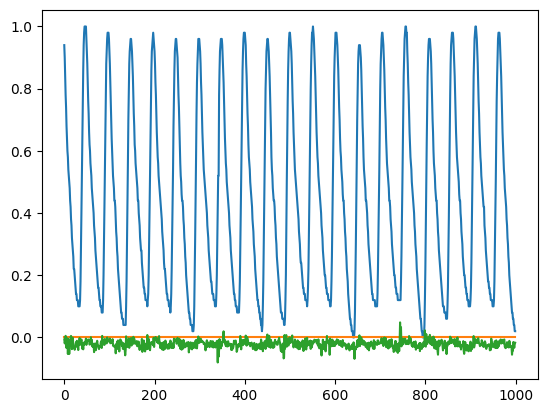

0.4347325


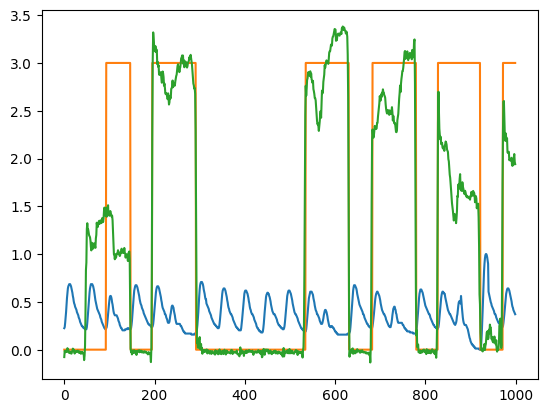

0.17209056


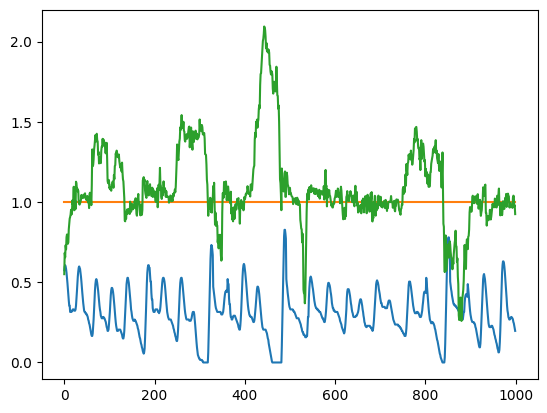

0.025150761


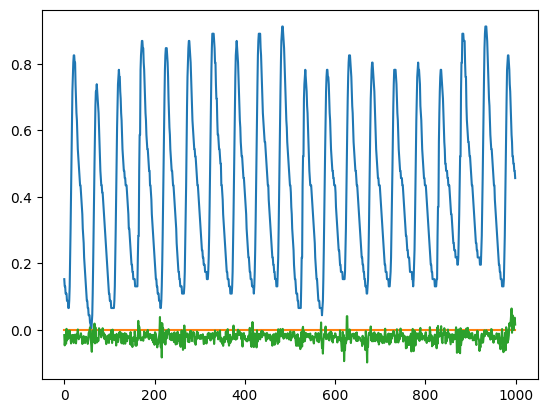

0.28217345


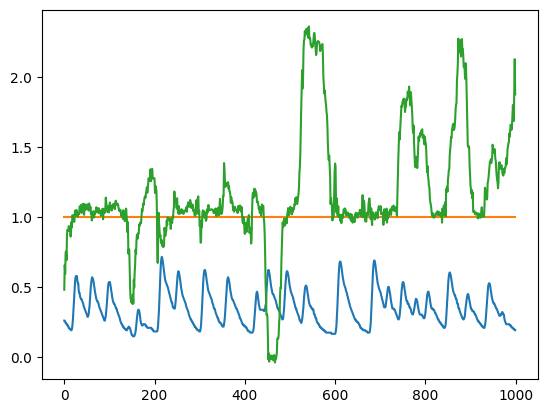

0.023151152


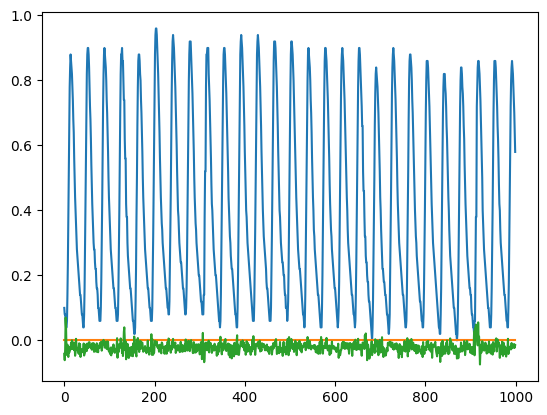

0.501542


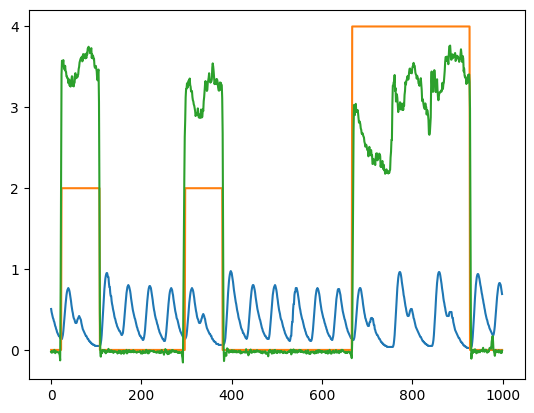

0.021991927


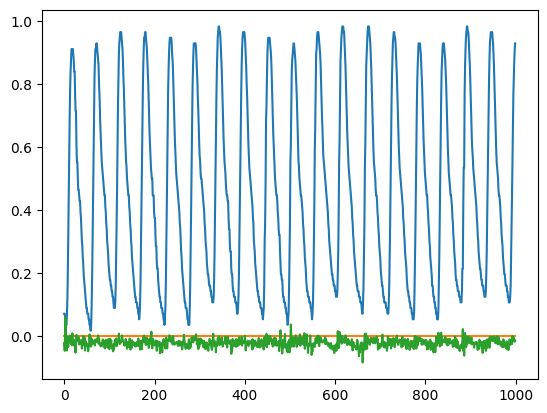

0.03157638


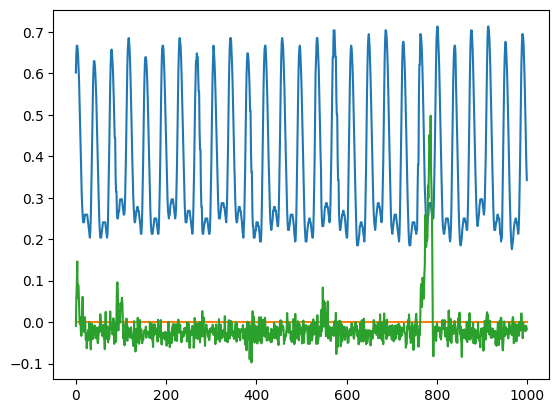

0.022767734


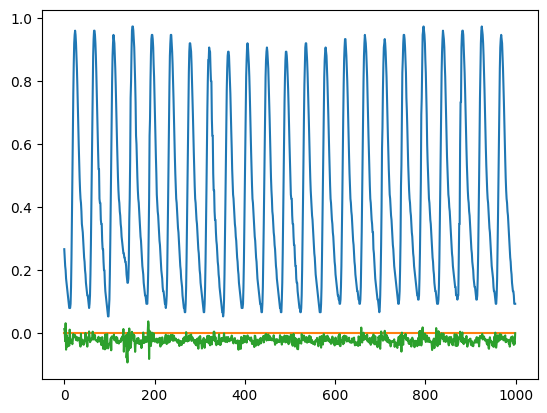

0.108461015


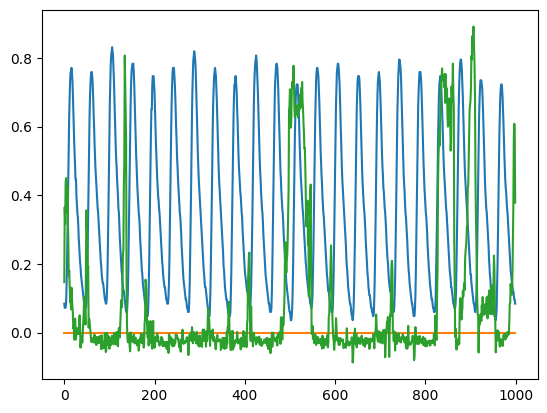

0.66579103


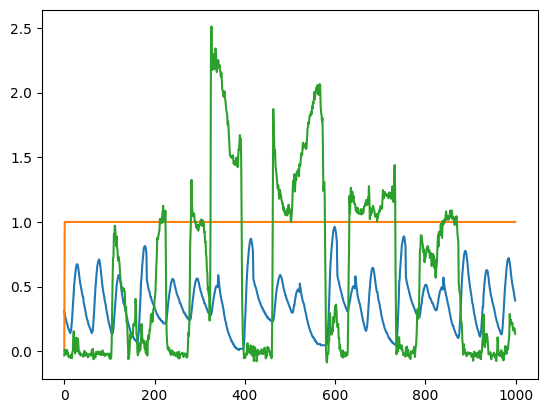

0.024511056


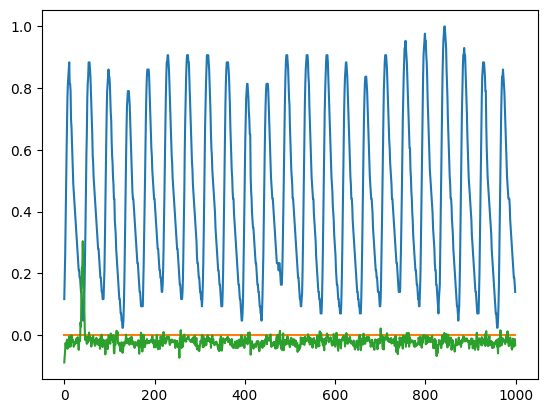

0.2384049


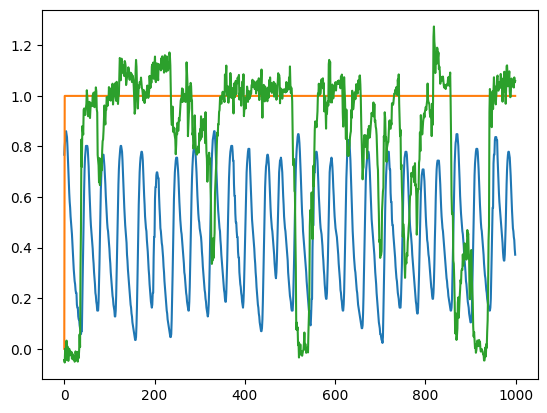

0.024527544


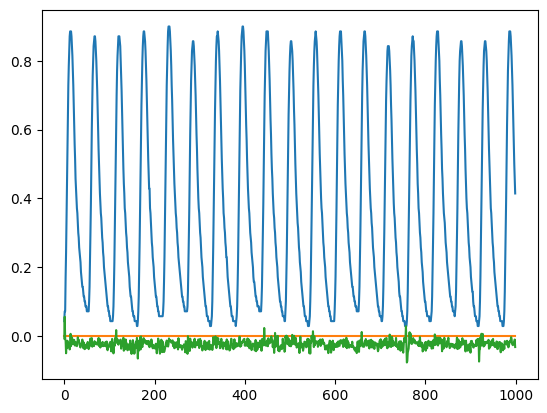

0.32617292


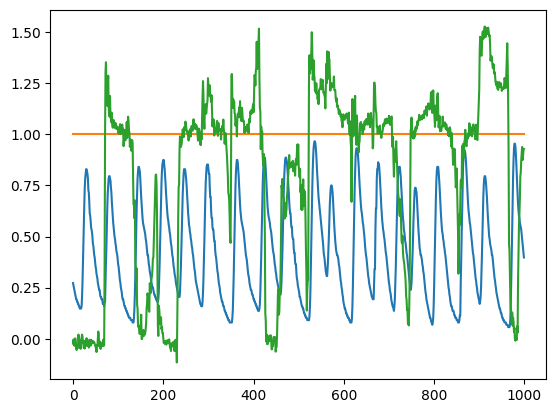

0.025775779


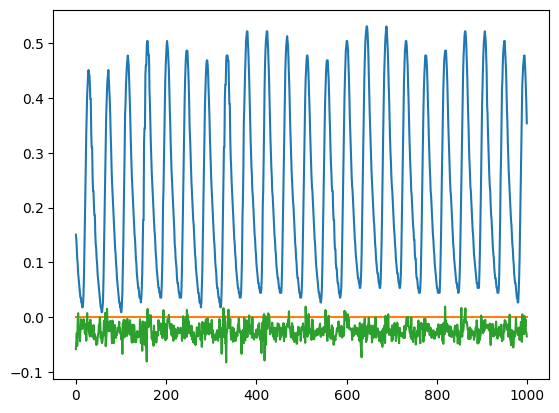

0.023824092


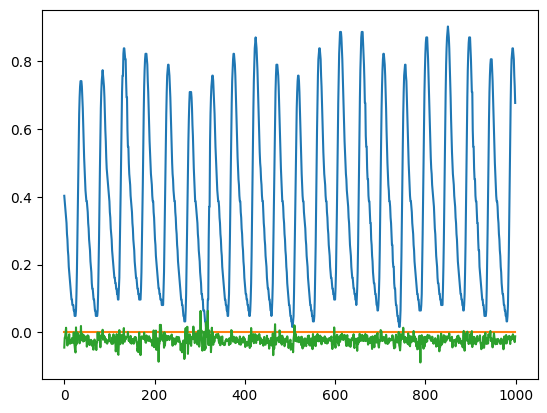

0.038110845


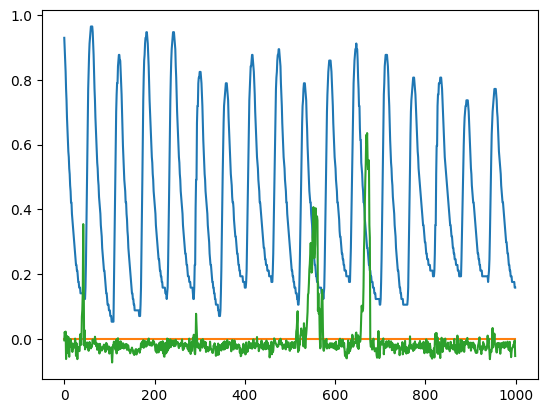

0.023735188


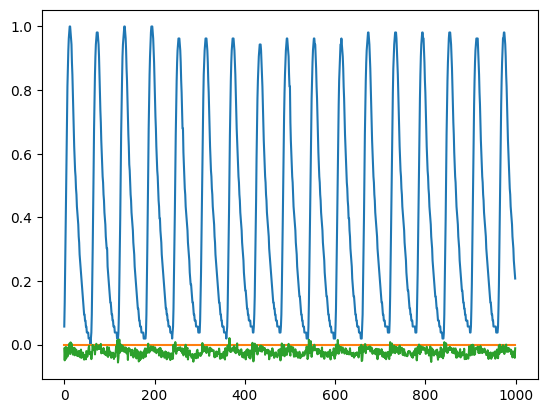

0.117830224


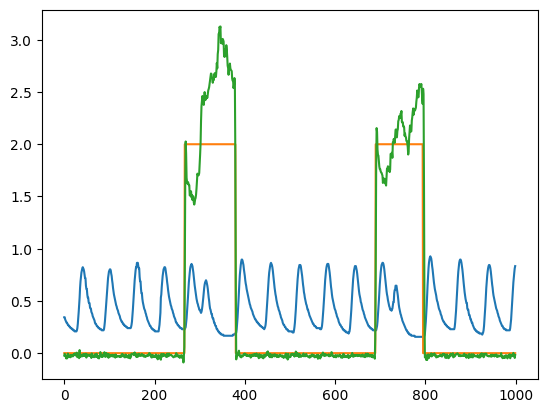

0.02184819


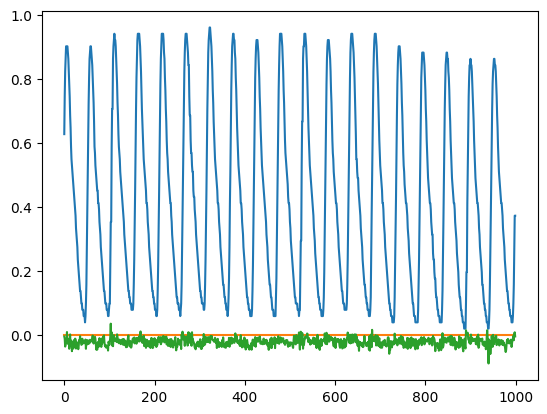

0.02553396


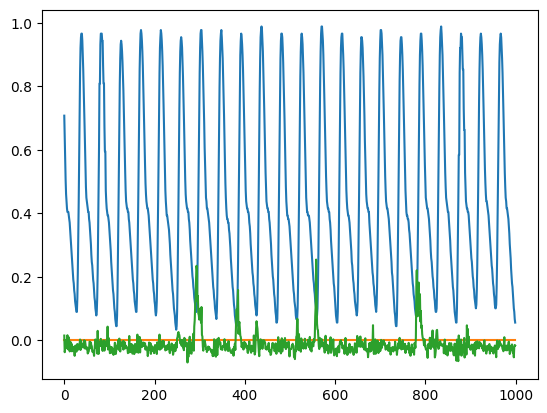

0.044850633


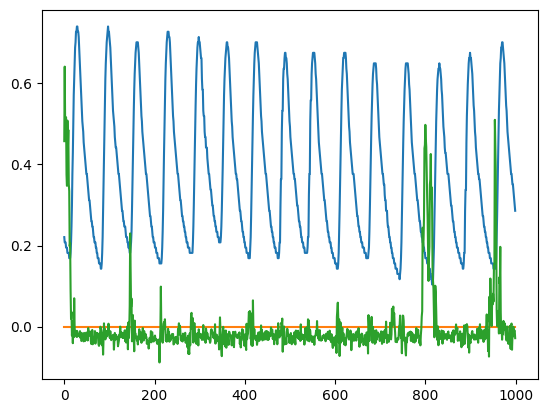

0.022996183


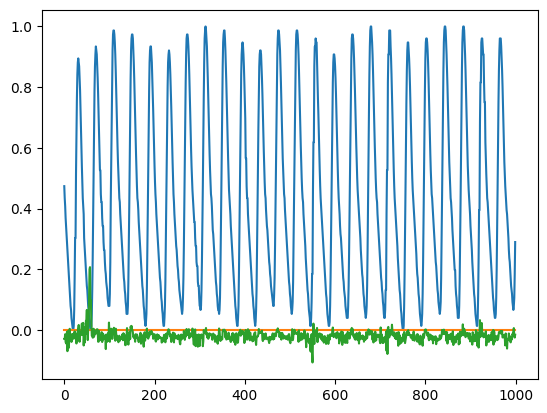

0.3027642


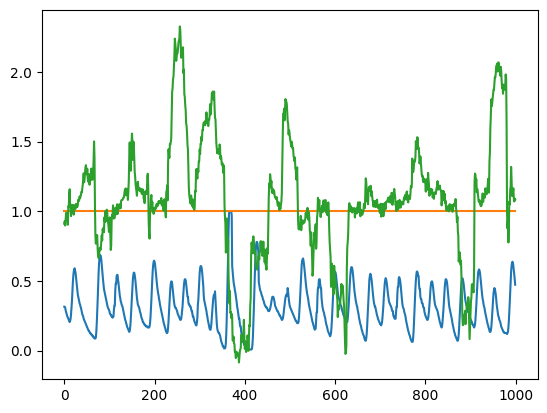

0.02453798


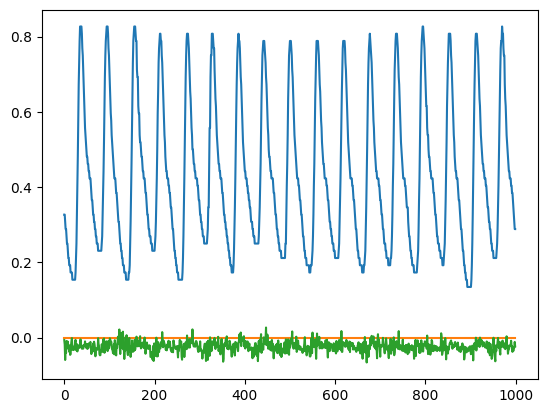

0.023306582


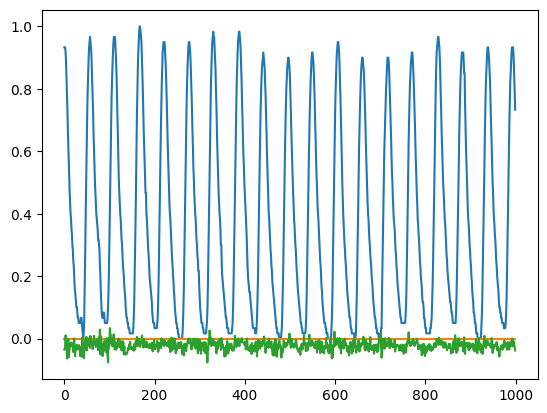

0.05336619


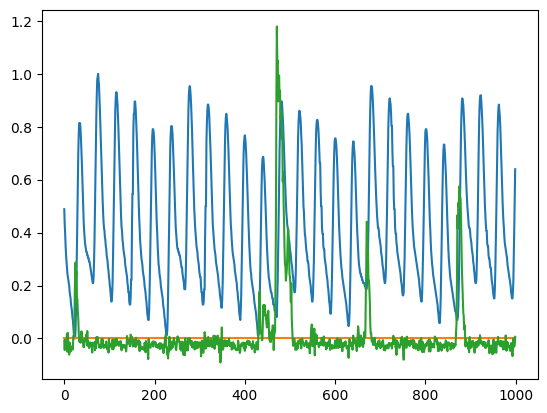

0.029406786


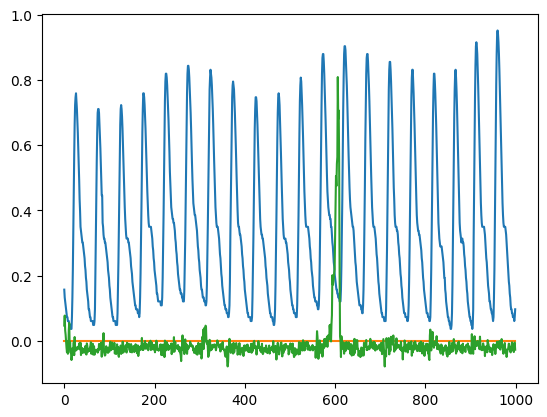

0.12806214


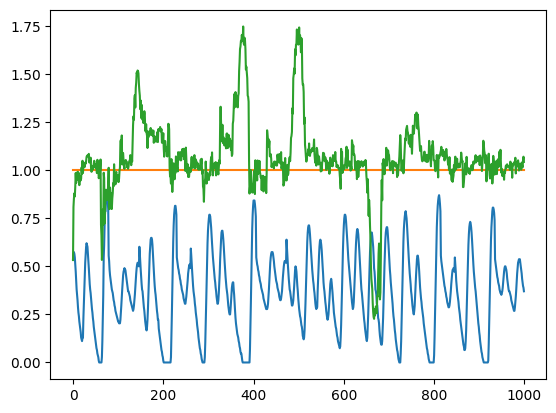

In [6]:
shower = performance()
shower.test(model,device,test_data,per_fnc = "series")
criterion = nn.L1Loss()
for i in range(100):
    output = torch.stack([test_data[i][1]]).to(device)
    input = torch.stack([test_data[i][0]]).to(device)
    y_hat = model.forward(input)
    loss = criterion(y_hat,output)
    # if loss.cpu().detach().numpy()<0.3:
    print(loss.cpu().detach().numpy())
    plt.plot(input.cpu().detach().numpy().flatten()[0:1000])
    plt.plot(output.cpu().detach().numpy().flatten()[0:1000])
    plt.plot(y_hat.cpu().detach().numpy().flatten()[0:1000])
    plt.show()